In [19]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader

In [20]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [21]:
# Extract from archive - no need if extracted once already
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [22]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['dog', 'truck', 'automobile', 'bird', 'horse', 'airplane', 'deer', 'cat', 'ship', 'frog']


In [23]:
# directory structure (one folder per class) is used by many computer vision datasets
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [24]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
show_example(*dataset[0])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

In [ ]:
# We can now create data loaders for training and validation, to load the data in batches
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [28]:
# We can look at batches of images from the dataset using the make_grid method from torchvision
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
show_batch(train_dl)

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #model1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            #nn.Dropout(p=0.4),

            nn.Flatten(), 
            
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
            #model2
            #nn.Conv2d(3, 32, kernel_size=3, padding=1),
            #nn.Tanh(),
            #nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.Tanh(),
            #nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            #nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.Tanh(),
                
            #nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            #nn.Dropout(0.4),

  
            #nn.Flatten(), 
            #nn.Linear(128*8*8, 1024),
            #nn.Tanh(),
            #nn.Dropout(0.2),
            #nn.Linear(1024, 512),
            #nn.Tanh(),
            #nn.Linear(512, 10))'''

            #model 3
            #nn.Conv2d(3, 32, kernel_size=3, padding=1),
            #nn.Sigmoid(),
            #nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.Sigmoid(),
            #nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            #nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.Sigmoid(),
    
            #nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            #nn.Dropout(0.4),

  
            #nn.Flatten(), 
            #nn.Linear(128*8*8, 1024),
            #nn.ReLU(),
            #nn.Dropout(0.2),
            #nn.Linear(1024, 512),
            #nn.ReLU(),
            #nn.Linear(512, 256), 
            #nn.ReLU(),
            #nn.Linear(256, 10))

        
    def forward(self, xb):
        return self.network(xb)



In [32]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We'll define two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set


In [33]:

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD,scheduler="",momentum=0):
    history = []
    if momentum != 0:
      optimizer = opt_func(model.parameters(), lr,momentum)
    else:
      optimizer = opt_func(model.parameters(), lr)
    if(scheduler == "plat"):
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5)
    elif(scheduler =="dec"):
      scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        if(scheduler == "plat"):
          scheduler.step(result['train_loss'])
        if(scheduler == "dec"):
          scheduler.step()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
num_epochs = 75
opt_func = torch.optim.SGD
lr = 0.05
momentum =0.9

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available), and use to_device to move our model to the GPU (if available)


In [ ]:
model = Cifar10CnnModel()
device = get_default_device().

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func,scheduler="dec",momentum=0.9)

In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_loss(history):
    accuracies = [x['train_loss'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. No. of epochs');

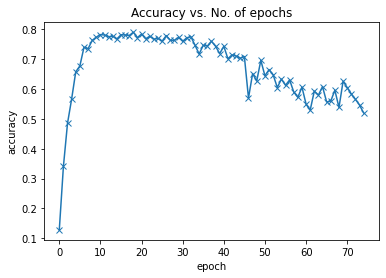

In [42]:
plot_accuracies(history)


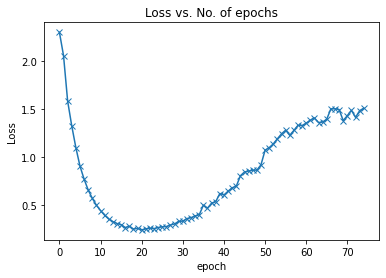

In [43]:
plot_loss(history)